In [120]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly.graph_objects as go
import numpy as np

In [3]:
# Load the dataset
# topical is detailed questionnaire of  one sampled child from the screener
topical_2022 = pd.read_stata('.\\datasets\\2022\\nsch_2022e_topical.dta')
topical_2021 = pd.read_stata('.\\datasets\\2021\\nsch_2021e_topical.dta')


# topical_2022.keys() #490
# topical_2021.keys() #463

# combined dataset
df = pd.concat((topical_2022, topical_2021))

# Overall Data Stats

In [4]:
df.keys() # 513
len(df) # 104995
df['k2q31a']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
50887    2.0
50888    2.0
50889    2.0
50890    1.0
50891    2.0
Name: k2q31a, Length: 104995, dtype: float64

In [5]:
# Combine diagnosis and severity into a new target variable ranging from 0 to 3
# k2q31a: add diagnosis 1 = yes, 2 = no
df['k2q31a'] = df['k2q31a'] == 1 #assign 0 to 'No' instead of 2
df = df.copy()
# k2q31b: add currently 1 = yes, 2 = no
df['k2q31b'] = df['k2q31b'] == 1 #assign 0 to 'No' instead of 2
df = df.copy()
# making ADD indicator variable (true/false)
# only classify as add if they were told they have it and currently still do
df['ADD_IND'] = df['k2q31a'] * df['k2q31b']
df = df.copy()

In [6]:
num_add = df['ADD_IND'].sum()
print("Number of ADD:", num_add)
print("Percentage ADD:", num_add/len(df) * 100)

Number of ADD: 9397
Percentage ADD: 8.949949997618935


Text(0.5, 1.0, 'Age distribution of children with ADHD')

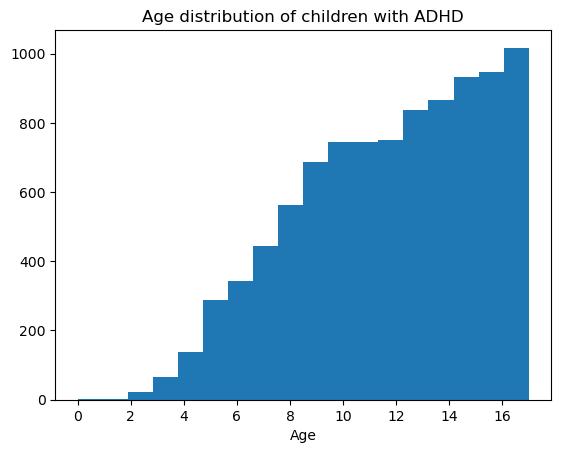

In [7]:
# age distribution of those with ADD
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
df[df['ADD_IND']].hist(column='sc_age_years', bins=18, ax=ax, grid=False)
ax.set_xlabel("Age")
ax.set_title("Age distribution of children with ADHD")

In [8]:
# grouping by fips code for state distribution of ADD/population (prevalence)
fips_group = df.groupby(['fipsst'])
fips_add_freq = fips_group['ADD_IND'].sum() / fips_group['fipsst'].sum()
# fips_add_freq = (fips_add_freq.to_frame(name='ADD_FREQ')).reset_index()
fips_add_freq = (np.log(fips_add_freq.to_frame(name='ADD_FREQ') * 1000)).reset_index()

In [9]:
states = [ 'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY',
          'LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND',
          'OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

fig = go.Figure(data=go.Choropleth(
    locations=states, # Spatial coordinates
    z = fips_add_freq['ADD_FREQ'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'blues',
    colorbar_title = "Log ADHD rate",
))

fig.update_layout(
    title_text = '2022 ADHD diagnoses per 1000 people (log scale)',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [10]:
# create severity
# k2q31c: add severity 1 = mild, 2 = moderate, 3 = severe
df['ADD_SEVERITY'] = df['ADD_IND'] * df['k2q31c'].fillna(0)

# seeing total of those that have an ADHD severity too
sum(df['ADD_SEVERITY'] != 0)

9325

# Overall Dataset Experimentation

In [11]:

# don't include: stratum (1 or 2a), householdid, formtype (1-3), k2q31d (add medication), any of previous targets
target_variable = 'ADD_IND'
ex_features = ['stratum', 'hhid', 'formtype', 'addtreat', 'k2q31d', 'k2q31a', 'k2q31c', 'k2q34c', 'k2q31b', 'ADD_SEVERITY']
data = df.drop(columns = ex_features)

# calculate n for each target category
noADD = (data[target_variable] == 0).sum()
sev1 = (data[target_variable] == 1).sum()
sev2 = (data[target_variable] == 2).sum()
sev3 = (data[target_variable] == 3).sum()

In [12]:
# Identify features with high correlation with the target

# get rid of strings
data_conv = data.select_dtypes(exclude=['object'])

# Convert categorical columns to numerical
# data_conv = data.copy()
# categ = ['inq_edu', 'inq_employ', 'inq_home', 'inq_income', 'inq_resseg']
# data_conv[categ] = data[categ].replace({'LOW': 0, 'HIGH': 1})

correlation_matrix = data_conv.corr()

# Extract the correlation of the target variable with all other variables (exclude the target variable)
target_correlation = correlation_matrix.loc[target_variable].sort_values(ascending=False).drop(target_variable)

highly_correlated_features = target_correlation[abs(target_correlation) > 0.2].index.tolist()

print("Features with high correlation with the target:")
print(highly_correlated_features)

Features with high correlation with the target:
['totcshcn', 'hcability', 'cystfib_desc', 'k7q83_r', 'k7q84_r', 'makefriend', 'k7q04r_r', 'k7q85_r', 'k7q82_r', 'k8q31', 'sesplanyr', 'k2q35a_1_years', 'k4q37', 'bullied_r', 'k8q32', 'sitstill', 'hcextent', 'focuson', 'sc_age_years', 'k6q71_r', 'bully', 'sc_k2q14', 'sc_k2q19', 'birth_yr', 'k2q34b', 'arrangehc', 'calmdown_r', 'k7q70_r', 'waitforturn', 'k2q35a', 'errandalone', 'ace11', 'k2q36a', 'sc_k2q16', 'menbevcov', 'k4q28x04', 'distracted', 'totnonshcn', 'k2q32a', 'k4q36', 'ssidisability', 'sc_k2q20', 'k6q15', 'k2q33a', 'autismmed', 'sc_k2q13', 'k4q22_r', 'k2q30a', 'sc_k2q10', 'sc_cshcn', 'sc_k2q22', 'k2q34a', 'memorycond', 'k4q23']


In [13]:
#K8Q31 ‐ How Often Have You Felt ‐ Child Hard to Care For (T1 T2 T3)
correlation_matrix.loc['k8q31', target_variable]

0.28977570299324945

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

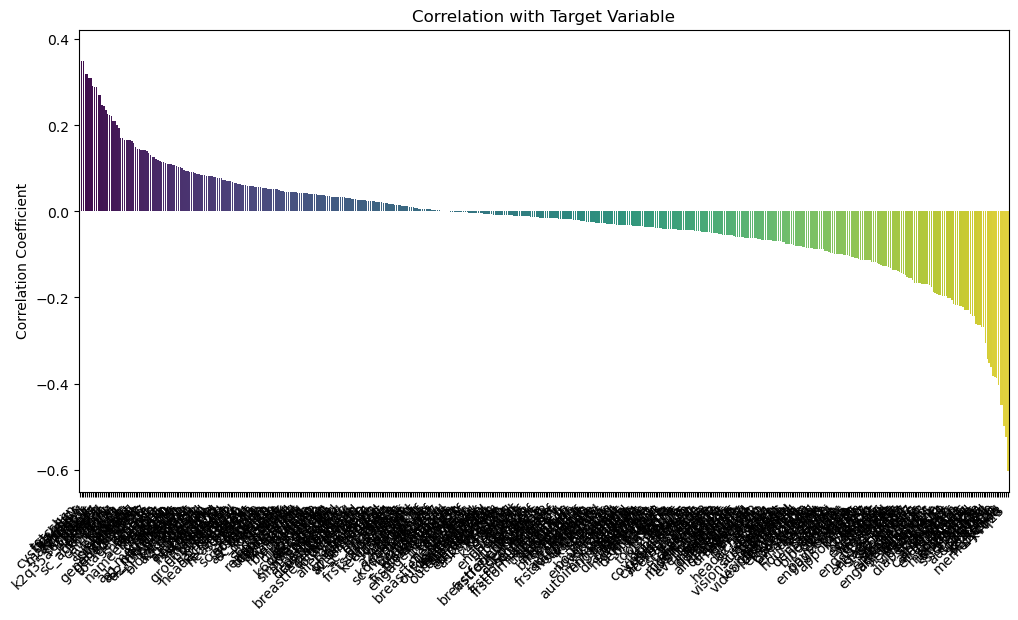

In [15]:
# Visualize Correlations with target variable
plt.figure(figsize=(12, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values, palette='viridis')
plt.title('Correlation with Target Variable')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [16]:
#Exclude further features that are co-variates of ADHD
# hcextent (health problems affect ability), sesplanyr (Spec. Edu Plan start), c4q04 (frustrated getting service), 
# k2q33c (anxiety sev), k4q37 (spec. services received), sc_k2q19 (special therapy), 
# arrangehc (hours arranging healthcare), k2q34b (behavior problems), k2q35a (Autism), ace11 (treated unfairly bc health condition), 
# k2q32a (depression), k4q36 (received spec. service), ssidisability (receive SSI), sc_k2q20 (spec. therapy for condition), 
# k6q15 (spec. educ. plan), k2q33a (anxiety), k2q30a (learning disability), k4q22_r (received treatment), autismmed (ASD medication), sc_k2q13 (use med care)
# sc_k2q10 (medication), sc_cshcn (spec. health care needs), sc_k2q22 (treatment), k2q34a (behavior problem), k4q23 (medication)
# menbevcov (insurance cov),  genetic_desc (genetic condition), k2q35a_1_years (first told ASD), k2q36a (dev delay)
# totnonshcn (children without special health care needs), totcshcn (children with special health care needs), k4q28x04 (needed mental health care not received), hcability (affects ability function)'
excluded = ['hcextent', 'sesplanyr', 'c4q04', 'k2q33c', 'k4q37', 'sc_k2q19', 'arrangehc', 'k2q34b', 'k2q35a', 
            'ace11', 'k2q32a', 'k4q36', 'ssidisability', 'sc_k2q20', 'k6q15', 'k2q33a', 'k2q30a', 'k4q22_r', 'autismmed', 'sc_k2q13', 'sc_k2q10', 'sc_cshcn', 
            'sc_k2q22', 'k2q34a', 'k4q23', 'menbevcov', 'genetic_desc', 'k2q35a_1_years', 'k2q38c', 'k2q36a',
           'totnonshcn', 'totcshcn', 'sc_age_years', 'sc_k2q14', 'birth_yr', 'k4q28x04', 'hcability']
data_ex = data_conv.drop(columns = excluded)
reduced_features = [feature for feature in highly_correlated_features if feature not in excluded]
data_final = data_ex[reduced_features + [target_variable]]

# Remove rows with missing values
final = data_final.fillna(0)

# Calculate the number of deleted rows due to NA
original_rows = data_conv.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[reduced_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.4
test_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state = 42)


Random Forest- Validation Accuracy: 0.92
              precision    recall  f1-score   support

       False       0.95      0.97      0.96     38283
        True       0.58      0.42      0.49      3715

    accuracy                           0.92     41998
   macro avg       0.76      0.70      0.72     41998
weighted avg       0.91      0.92      0.92     41998

[[37146  1137]
 [ 2147  1568]]


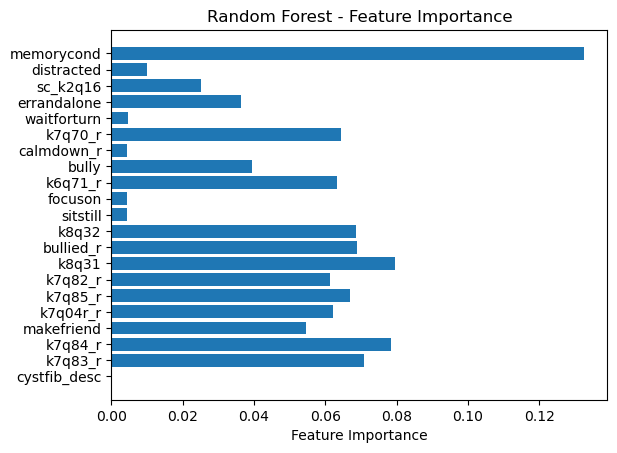

In [17]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Random Forest- Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(reduced_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

Logistic Regression - Validation Accuracy: 0.92
              precision    recall  f1-score   support

       False       0.94      0.98      0.96     38283
        True       0.64      0.35      0.45      3715

    accuracy                           0.92     41998
   macro avg       0.79      0.67      0.71     41998
weighted avg       0.91      0.92      0.91     41998

[[37548   735]
 [ 2417  1298]]


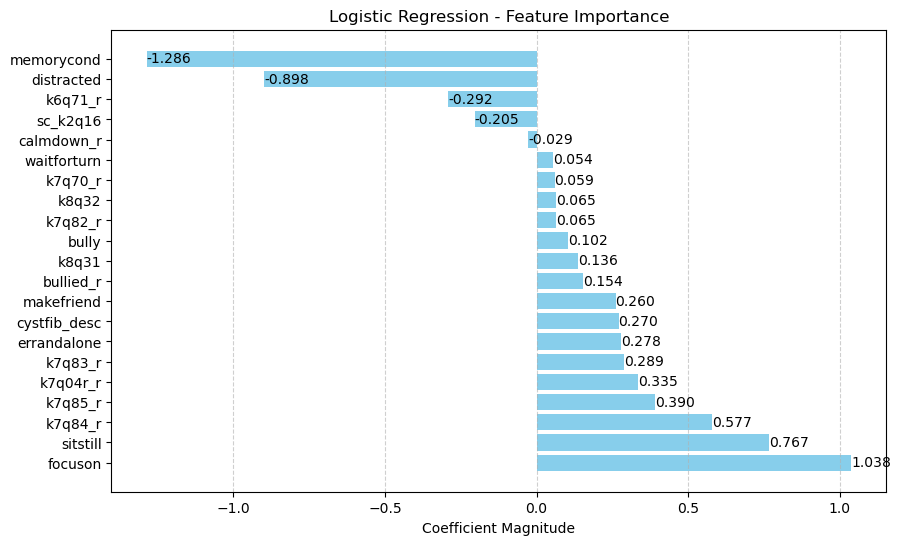

In [18]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

Best Model - Test Accuracy: 0.92
              precision    recall  f1-score   support

       False       0.94      0.98      0.96      9559
        True       0.63      0.34      0.44       941

    accuracy                           0.92     10500
   macro avg       0.78      0.66      0.70     10500
weighted avg       0.91      0.92      0.91     10500

[[9372  187]
 [ 624  317]]


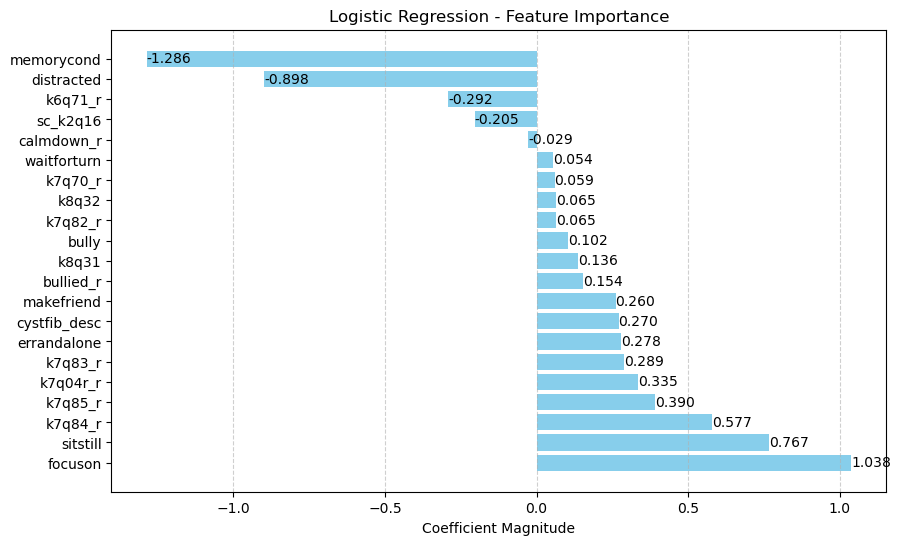

In [19]:
# Choose the best model and evaluate on the test set
best_model = LogisticRegression(max_iter = 1000)  # Change this based on the best-performing model from validation
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Mangitude of Coefficients
coefficients = best_model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

# Lifestyle, Parental, Socioeconomic Variable feature selection


Below is a list of (most) every single variable and the rough categories it falls under: Lifestyle, Parental, Socioeconomic, Exclude (symptoms/behavioral), and Exclude (covariate). The full list can be found here: https://www2.census.gov/programs-surveys/nsch/technical-documentation/codebook/2022-NSCH-Topical-Variable-List.pdf

During feature selection, some variables were then excluded, or moved to other categories.

### Lifestyle
- AUTOIMMUNE ‐ Autoimmune Disease (T1 T2 T3)
- AVOIDCHG ‐ Past 12 Months ‐ Avoided Changing Jobs to Maintain Health Insurance (T1 T2 T3)
- BEDTIME ‐ How Often ‐ Go to Bed at Same Time (T1 T2 T3)
- BIRTH_MO ‐ Birth Month (T1 T2 T3)
- BIRTH_YR ‐ Birth Year (T1 T2 T3)
- BIRTHWT ‐ Birth Weight Status (T1 T2 T3)
- BIRTHWT_OZ_S ‐ Standardized Birth Weight, Ounces (T1 T2 T3)
- BLOOD ‐ Blood Disorder (T1 T2 T3)
- BMICLASS ‐ Body Mass Index, Percentile (T2 T3)
- BODYIMAGE ‐ Child's concern over body image  (T2 T3)
- BORNUSA ‐ Born in the United States (T1 T2 T3)
- BOUNCEABALL ‐ Bounce Ball (T1)
- BREASTFEDEND_MO_S ‐ Stopped Breastfeeding ‐ Months (Standardized) (T1)
- BULLIED_R ‐ Bullied, Picked On, or Excluded by Others (T2 T3)
- BULLY ‐ Bullies Others, Picks on Them, or Excludes Them (T2 T3)
- CAVITIES ‐ Difficulty Cavities Past 12 Months (T1 T2 T3)
- CONCUSSION ‐ Concussion/Brain Injury (T1 T2 T3)
- CONFIRMINJURY ‐ Concussion/Brain Injury ‐ Confirmed Injury (T1 T2 T3)
- COVIDARRANGE ‐ COVID ‐ Closed School or Daycare (T1 T2)
- FRSTFORMULA_MO_S ‐ First Fed Formula ‐ Months (Standardized) (T1)
- FRSTSOLIDS_MO_S ‐ First Fed Solids ‐ Days (Standardized) (T1)
- FRUIT ‐ How Many Fruits (T1)
- GOFORHELP ‐ Know Where to Go For Help (T1 T2 T3)
- GUMBLEED ‐ Difficulty Bleeding Gums Past 12 Months (T1 T2 T3)
- HEIGHT ‐ Height in CM (T2 T3)
- HHCOUNT ‐ Number of People Living at Address (T1 T2 T3)
- HIGRADE ‐ Highest Level of Education among Reported Adults (T1 T2 T3)
- HIGRADE_TVIS ‐ Highest Level of Education among Reported Adults, Detail (T1 T2 T3)
- HOPEFUL ‐ Facing Problems ‐ How Often Stay Hopeful (T1 T2 T3)
- INQ_EDU ‐ Black‐White educational inequity (Supplemental)
- INSGAP ‐ Health Insurance Coverage ‐ Past 12 Months (T1 T2 T3)
- INSTYPE ‐ Insurance Type (Revised) (T1 T2 T3)
- K10Q11 ‐ Neighborhood ‐ Sidewalks or Walking Paths (T1 T2 T3)
- K10Q12 ‐ Neighborhood ‐ Park or Playground (T1 T2 T3) to K10Q41_R ‐ Child Is Safe at School (T2 T3)
- K11Q43R ‐ How Many Times Moved to New Address (T1 T2 T3)
- K12Q03 ‐ Health Insurance ‐ Current/Former Employer or Union (T1 T2 T3)
- K2Q01 ‐ General Health (T1 T2 T3)
- K2Q01_D ‐ Teeth Description (T1 T2 T3)
- K2Q05 ‐ Born 3 or More Weeks Before Due Date (T1 T2 T3)
- K4Q04_R ‐ Personal Doctor or Nurse ‐ One or More (T1 T2 T3)
- K4Q20R ‐ Preventive Visit ‐ How Many Times (T1 T2 T3)
- K4Q30_R_1 ‐ Dental Provider Visit ‐ Dentist (T1 T2 T3) 
- K5Q40 ‐ How Often ‐ Spend Enough Time (T1 T2 T3) 
- K6Q27 ‐ Job Change Because Problems with Child Care (T1) 
- K6Q40 ‐ Ever Breastfed (T1) 
- K6Q60_R ‐ How Many Days Read to Child (T1) 
- K6Q61_R ‐ How Many Days Tell Stories or Sing to Child (T1) 
- METRO_YN ‐ Metropolitan Statistical Area Status (Operational) 
- MOMAGE ‐ Age of Mother ‐ Years (T1 T2 T3) 
- MPC_YN ‐ Metropolitan Principal City Status (Operational) 
- OUTDOORSWKDAY ‐ Time Spent Playing Outdoors ‐ Weekday (T1) 
- OUTDOORSWKEND ‐ Time Spent Playing Outdoors ‐ Weekend (T1) 
- OVERWEIGHT ‐ Doctor Identified as Overweight (T1 T2 T3) 
- PHYSACTIV ‐ Exercise, Play Sport, or Physical Activity for 60 Minutes (T2 T3) 
- PLACESLIVED ‐ Number of placed the child has lived  (T1 T2 T3) 
- RECEVALFASD ‐ Received an Evaluation for FASD (T1 T2 T3) 
- S4Q01 ‐ Doctor Visit (T1 T2 T3) 
- LIVEUSA_MO ‐ How Long Living in the United States ‐ Months (T1 T2 T3) 
- LIVEUSA_YR ‐ How Long Living in the United States ‐ Years (T1 T2 T3) 
- SC_AGE_YEARS ‐ Age of Selected Child ‐ In Years (S1) 
- SC_ENGLISH ‐ SC  Speaks English (S1) 
- SCREENTIME ‐ How Much Time Spent with TV, Cellphone, Computer (T1 T2 T3) 
- SEEKCARE ‐ Concussion/Brain Injury ‐ Seek Care (T1 T2 T3) 
- STARTSCHOOL ‐ Has Child Started School (T1) 
- STOMACH ‐ Difficulty Stomach Past 12 Months (T1 T2 T3) 
- STRENGTHS ‐ Facing Problems ‐ How Often Draw on Strengths (T1 T2 T3) 
- SUGARDRINK ‐ How Many Surgary Drinks (T1) 
- TALKABOUT ‐ Facing Problems ‐ How Often Talk Together (T1 T2 T3) 
- TOTAGE_12_17 ‐ Count of Children Ages 12 to 17 in Household (S1) 
- VAPE ‐ Vape/E‐Cigarettes inside of Home (T1 T2 T3) 
- VEGETABLES ‐ How Many Vegetables (T1) 
- WEIGHT ‐ Weight in KG (T2 T3) 
- WKTOSOLVE ‐ Facing Problems ‐ How Often Work Together (T1 T2 T3) 
- K9Q40 ‐ Anyone in Household Use Cigarettes (T1 T2 T3) 
- ACE10 ‐ Child Experienced ‐ Treated Unfairly Because of Race (T1 T2 T3)
- ACE12 ‐ Child Experienced ‐ Treated Unfairly Because of their Sexual Orientation or Gender Identity (T2 T3)
- HHLANGUAGE ‐ Primary Household Language (S1)
- HOUSE_GEN ‐ Parental Nativity (T1 T2 T3)
- SC_AIAN ‐ American Indian or Alaska Native Alone or in Combination with Other Race (T1 T2 T3)
- SC_ASIAN ‐ Asian Alone or in Combination with Other Race (T1 T2 T3) 
- SC_HISPANIC_R ‐ Hispanic Origin of Selected Child, Recode (S1) 
- SC_NHPI ‐ Native Hawaiian or Other Pacific Islanders Alone or in Combination with Other Race (T1 T2 T3)
- SC_RACE_R ‐ Race of Selected Child, Detailed (S1) 
- SC_RACER ‐ Race of Selected Child, Recode (S1) 
- SC_SEX ‐ Sex of Selected Child (S1) 

### Parental
- A1_ACTIVE ‐ Adult 1 ‐ Active Duty (T1 T2 T3)
- A1_AGE ‐ Adult 1 ‐ Age in Years (T1 T2 T3)
- A1_BORN ‐ Adult 1 ‐ Where Born (T1 T2 T3)
- A1_DEPLSTAT ‐ Adult 1 ‐ Deployment Status (T1 T2 T3)
- A1_EMPLOYED ‐ Adult 1 ‐ Current Employment Status (T1 T2 T3)
- A1_GRADE ‐ Adult 1 ‐ Highest Completed Year of School (T1 T2 T3)
- A1_LIVEUSA ‐ Adult 1 ‐ Come to Live in the United States (Year) (T1 T2 T3)
- A1_MARITAL ‐ Adult 1 ‐ Marital Status (T1 T2 T3)
- A1_MENTHEALTH ‐ Adult 1 ‐ Mental or Emotional Health (T1 T2 T3)
- A1_PHYSHEALTH ‐ Adult 1 ‐ Physical Health (T1 T2 T3)
- A1_RELATION ‐ Adult 1 ‐ How Related to Child (T1 T2 T3)
- A1_SEX ‐ Adult 1 ‐ Sex (T1 T2 T3)
- All of the above, for A2 (Adult 2)
- ACE3 ‐ Child Experienced ‐ Parent or Guardian Divorced (T1 T2 T3)
- ACE4 ‐ Child Experienced ‐ Parent or Guardian Died (T1 T2 T3)
- ACE5 ‐ Child Experienced ‐ Parent or Guardian Time in Jail (T1 T2 T3)
- ACE6 ‐ Child Experienced ‐ Adults Slap, Hit, Kick, Punch Others (T1 T2 T3)
- ACE7 ‐ Child Experienced ‐ Victim of Violence (T1 T2 T3) 
- ACE8 ‐ Child Experienced ‐ Lived with Mentally Ill (T1 T2 T3) 
- ACE9 ‐ Child Experienced ‐ Lived with Person with Alcohol/Drug Problem (T1 T2 T3) 
- AGEPOS4 ‐ Birth Order of Selected Children in Household (S1) 
- ALLERGIES ‐ Allergies (T1 T2 T3) 
- ALTHEALTH ‐ Alternative Health Care (T1 T2 T3)
- APPOINTMENT ‐ Needed Health Care Not Received Due to ‐ Getting Appointment (T1 T2 T3)
- 
### Socioconomic
- A1_EMPLOYED ‐ Adult 1 ‐ Current Employment Status (T1 T2 T3)
- ACE1 ‐ Hard to Cover Basics Like Food or Housing (T1 T2 T3)
- CURRCOV ‐ Health Insurance Coverage ‐ Currently Covered (Use CURRINS) (T1 T2 T3)
- CUTHOURS ‐ Past 12 Months ‐Cut Hours because of Health Conditions (T1 T2 T3)
- DECISIONS ‐ Health Care Decisions Needed (T1 T2 T3)
- EBTCARDS ‐ School Meal Debit  (T1 T2 T3)
- EVERHOMELESS ‐ Homeless or Lived in Shelter  (T1 T2 T3)
- EYECARE1 ‐ Eye Doctor Care ‐ Examination (T1 T2 T3)
- FOODSIT ‐ Food Situation In Household ‐ Past 12 Months (T1 T2 T3)
- FPL_I1 ‐ Family Poverty Ratio, First Implicate (T1 T2 T3)
- HOMEEVIC ‐ Worried about Being Evicted  (T1 T2 T3)
- ISSUECOST ‐ Needed Health Care Not Received Due to ‐ Cost (T1 T2 T3)
- K11Q60 ‐ Cash Assistance from Government ‐ Past 12 Months (T1 T2 T3)
- K11Q61 ‐ Food Stamps ‐ Past 12 Months (T1 T2 T3)
- K11Q62 ‐ Free or Reduced Cost Meals ‐ Past 12 Months (T1 T2 T3)
- K12Q01_A ‐ Reason Not Covered ‐ Change in Employer/Employment (T1 T2 T3)
- K3Q04_R ‐ Health Insurance Coverage ‐ Past 12 Months (Use INSGAP) (T1 T2 T3)
- K3Q20 ‐ Health Insurance ‐ Benefits Cover Services (T1 T2 T3)
- K3Q21B ‐ How Often Costs Reasonable (T1 T2 T3)
- K3Q25 ‐ Problems Paying for Medical or Health Care (T1 T2 T3)
- K4Q27 ‐ Needed Health Care Not Received (T1 T2 T3) 
- MISSMORTGAGE ‐ Not Able to Pay Mortgage or Rent (T1 T2 T3) 
- S9Q34 ‐ WIC Benefits ‐ Past 12 Months (T1 T2 T3) 
- SSI ‐ Receive SSI  (T1 T2 T3) 
- TENURE ‐ The Conditions under Which Land or Buildings Are Held or Occupied (S1)  

### MAYBE EXCLUDE (Symptoms/Behavioral)
Other diseases, potential behaviors that result in a diagnosis of ADHD
Actions related to the child themselves

- CYSTFIB ‐ Cystic Fibrosis (T1 T2 T3) 
- DIABETES ‐ Diabetes (T1 T2 T3)
- DOCPRIVATE ‐ Child Spoke with Doctor Privately (T3)
- ENGAGE_BINGE ‐ Eating Engagement ‐ Binging (T2 T3)
- ENGAGE_EXERCISE ‐ Eating Engagement ‐ Over‐Exercise (T2 T3)
- ENGAGE_FAST ‐ Eating Engagement ‐ Fasting (T2 T3)
- More eating habits
- ERRANDALONE ‐ Difficulty Doing Errands Alone (T3)
- GAINSKILLS ‐ Doctor Worked with Child to Gain Skills to Manage Health (T3)
- GENETIC ‐ Genetic Condition (T1 T2 T3)
- HANDS ‐ Difficulty Hands Past 12 Months (T1)
- HEADACHE ‐ Headaches (T1 T2 T3)
- HEALTHKNOW ‐ How Child Will Be Insured as an Adult (T3)
- HEART ‐ Heart Condition (T1 T2 T3)
- HEMOPHILIA ‐ Blood Disorder Hemophilia (T1 T2 T3)
- HOSPITALER ‐ Hospital Emergency Room Visits (T1 T2 T3)
- K2Q40A ‐ Asthma (T1 T2 T3)
- K2Q42A ‐ Epilepsy (T1 T2 T3)
- K2Q43B ‐ Deafness (T1 T2 T3)
- K4Q24_R ‐ Specialist Visit (T1 T2 T3) 
- K5Q41 ‐ How Often ‐ Listen Carefully (T1 T2 T3) 
- K5Q42 ‐ How Often ‐ Show Sensitivity (T1 T2 T3) 
- K5Q43 ‐ How Often ‐ Provide Specific Information (T1 T2 T3) 
- K5Q44 ‐ How Often ‐ Feel Like a Partner (T1 T2 T3) 
- K7Q02R_R ‐ Days Child Missed School ‐ Illness or Injury (T2 T3) 
- K8Q11 ‐ How Many Days ‐ Family Eat Meal Together (T1 T2 T3) 
- K8Q21 ‐ Share Ideas or Talk About Things That Matter (T2 T3) 
- K8Q30 ‐ How Well Handling Demands of Raising Children (T1 T2 T3) 
- K8Q35 ‐ Someone to Turn To for Emotional Support (T1 T2 T3) 
- K9Q96 ‐ Other Adult Child Can Rely On For Advice (T2 T3) 
- KEEPINSADULT ‐ How to Obtain/Keep Health Insurance as Child Becomes Adult (T3) 


- ASKQUESTION ‐ Ask Questions: Who, What, When, Where (T1)
- ASKQUESTION2 ‐ Ask Questions:  Why, How (T1)
- CALMDOWN_R ‐ How Often ‐ Calms Down When Excited (T1)
- CLEAREXP ‐ How Often ‐ Explain Things Good Idea (T1)
- COORDINATION ‐ Difficulty Coordination Past 12 Months (T1)
- COUNTTO_R ‐ Can Count How High (T1)
- DIRECTIONS ‐ Follow Verbal Directions (T1)
- DIRECTIONS2 ‐ Follow Two Step Directions (T1)
- DISTRACTED ‐ How Often ‐ Easily Distracted (T1)
- DRAWACIRCLE ‐ Draw a Circle (T1)
- DRAWAFACE ‐ Draw a Face (T1)
- DRAWAPERSON ‐ Draw a Person (T1)
- DRESSING ‐ Difficulty Dressing or Bathing (T2 T3)
- FOCUSON ‐ Focus on a Task (T1)
- GRADES ‐ Grades Received in School  (T2 T3)
- GROUPOFOBJECTS ‐ Group of Objects (T1)
- HARDWORK ‐ How Often ‐ Work even when hard  (T1)
- HOURSLEEP ‐ Past Week ‐ How Many Hours of Sleep Average (T2 T3)
- HOURSLEEP05 ‐ Past Week ‐ How Many Hours of Sleep Average (T1)
- HURTSAD ‐ How Often ‐ Show Concern (T1)
- K6Q70_R ‐ Affectionate (T1) 
- K6Q71_R ‐ Show Interest and Curiosity (T1 T2 T3) 
- K6Q72_R ‐ Smiles Laughs (T1) 
- K6Q73_R ‐ Bounces Back (T1) 
- K7Q04R_R ‐ Times School Contacted Household About Problems (T2 T3) 
- K7Q30 ‐ Sports Team or Sports Lessons ‐ Past 12 Months (T2 T3) 
- K7Q31 ‐ Clubs or Organizations ‐ Past 12 Months (T2 T3) 
- K7Q32 ‐ Organized Activities or Lessons ‐ Past 12 Months (T2 T3) 
- K7Q33 ‐ How Often Attend Events or Activities (T2 T3) 
- K7Q37 ‐ Community Service or Volunteer Work ‐ Past 12 Months (T2 T3) 
- K7Q38 ‐ Paid Work or Regular Job ‐ Past 12 Months (T2 T3) 
- K7Q70_R ‐ Argues Too Much (T2 T3) 
- K7Q82_R ‐ Cares About Doing Well in School (T2 T3) 
- K7Q83_R ‐ Does All Required Homework (T2 T3) 
- K7Q84_R ‐ Works to Finish Tasks Started (T2 T3) 
- K7Q85_R ‐ Stays Calm and In Control When Challenged (T2 T3) 
- K8Q31 ‐ How Often Have You Felt ‐ Child Hard to Care For (T1 T2 T3) 
- K8Q32 ‐ How Often Have You Felt ‐ Child Really Bothers You (T1 T2 T3) 
- K8Q34 ‐ How Often Have You Felt ‐ Angry with Child (T1 T2 T3) 
- MAKEFRIEND ‐ Difficulty Making or Keeping Friends (T2 T3) 
- MEMORYCOND ‐ Serious Difficulty Concentrating, Remembering, or Making Decisions (T2 T3) 
- NAMEEMOTIONS ‐ Recognize Emotion (T1) 
- ONEWORD ‐ Say One Word (T1) 
- PLAYWELL ‐ How Often ‐ Play Well with Others (T1) 
- POINT ‐ Point to Things (T1) 
- POSCHOICE ‐ Doctor Worked with Child to Make Positive Choices (T3) 
- RAISECONC ‐ How Often ‐ Easy to Raise Concerns or Disagree (T1 T2 T3) 
- READONEDIGIT ‐ Read One Digit (T1) 
- RECOGABC ‐ Recognize Letters of Alphabet (T1) 
- RECOGBEGIN ‐ Recognize Beginning Sound of a Word (T1) 
- REPEATED ‐ Child Repeated Any Grades (T2 T3) 
- RHYMEWORD_R ‐ Rhyme Words (T1) 
- SAMESOUND ‐ Words with Same Start Sound (T1) 
- SC_K2Q16 ‐ SC Limited Ability (S1) 
- SHARETOYS ‐ Share Toys (T1) 
- SIMPLEADDITION ‐ Simple Addition (T1) 
- STARTNEWACT ‐ How Often ‐ Difficulty End/Starting Activities (T1) 
- TELLSTORY ‐ Tell a Story (T1) 
- TEMPER_R ‐ How Often ‐ Loses Temper (T1)
- THREEWORDS ‐ Use Three Words Together (T1) 
- TWOWORDS ‐ Use Two Words Together (T1) 
- UNDERSTAND ‐ Understand "No" (T1) 
- UNDERSTAND2 ‐ Understand "In", "On", "Under" (T1) 
- VISIONSCREENOTHER ‐ Vision Screening from Other Provider (T1 T2 T3) 
- WAITFORTURN ‐ How Often ‐ Waits for Their Turn (T1) 
- WALKSTAIRS ‐ Serious Difficulty Walking or Climbing Stairs (T2 T3) 
- WRITENAME ‐ How Often ‐ Write First Name (T1) 
- 
### EXCLUDED
Things related to going to the hospital more often or direct diagnoses or ADHD, or other
- ARRANGEHC ‐ Hours Spent Arranging Health Medical Care (T1 T2 T3)
- ADDTREAT ‐ ADD/ADHD ‐ Behavioral Treatment (T1 T2 T3)
- ATHOMEHC ‐ Hours Spent Providing Home Health Care (T1 T2 T3)
- AUTISM
- BESTFORCHILD ‐ How Often ‐ Work to Decide Together Treatment (T1 T2 T3)
- BLINDNESS ‐ Blindness (T1 T2 T3)
- C4Q04 ‐ Frustrated In Efforts to Get Service (T1 T2 T3)
- CBSAFP_YN ‐ Core Based Statistical Area Status (Operational)
- CERPALS_DESC ‐ Cerebral Palsy Severity Description (T1 T2 T3)
- CHANGEAGE ‐ Doctor Worked with Child to Understand Health Care Changes (T3)
- DENTALSERV1 ‐ Dental Service ‐ Check‐up (T1 T2 T3)
- DISCUSSOPT ‐ How Often ‐ Provider Discussed Range of Options (T1 T2 T3)
- DOWNSYN ‐ Down Syndrome (T1 T2 T3)
- EMOSUPADV ‐ Emotional Support ‐ Health Condition Support Group (T1 T2 T3)
- EVALFASD ‐ Evaluation for a Fetal Alcohol Spectrum Disorder Recommended (T1 T2 T3)
- FIPSST ‐ State FIPS Code (Operational)
- HCABILITY ‐ Health Affected Ability ‐ How Often (T1 T2 T3)
- HCCOVOTH ‐ Health Insurance ‐ Other (T1 T2 T3)
- HCEXTENT ‐ Health Affected Ability ‐ Extent (T1 T2 T3)
- HOWMUCH ‐ How Much Medical Health Care ‐ Past 12 Months (T1 T2 T3)
- K2Q30A ‐ Learning Disability (T1 T2 T3)
- K2Q31D ‐ ADD/ADHD ‐ Medication Currently (T1 T2 T3)
- K2Q32A ‐ Depression (T1 T2 T3)
- K2Q33A ‐ Anxiety (T1 T2 T3)
- K2Q34A ‐ Behavior Problems (T1 T2 T3)
- K2Q35A ‐ Autism ASD (T1 T2 T3)
- K2Q36A ‐ Developmental Delay (T1 T2 T3)
- K2Q37A ‐ Speech Disorder (T1 T2 T3)
- K2Q38A ‐ Tourette Syndrome (T1 T2 T3)
- K2Q60A ‐ Intellectual Disability (T1 T2 T3)
- K2Q61A ‐ Cerebral Palsy (T1 T2 T3)
- K4Q01 ‐ Place Usually Goes Sick (T1 T2 T3)
- K4Q02_R ‐ Place Usually Goes Sick ‐ Where (T1 T2 T3)
- K4Q22_R ‐ Mental Health Professional Treatment (T1 T2 T3) 
- K4Q23 ‐ Emotions Concentration Behavior Medication (T1 T2 T3) 
- K4Q36 ‐ Received Special Services (T1 T2 T3) 
- K5Q10 ‐ Need a Referral (T1 T2 T3) 
- K5Q20_R ‐ Arrange Or Coordinate Care Among Doctors (T1 T2 T3) 
- K5Q30 ‐ Communication Satisfaction Among Doctors (T1 T2 T3) 
- K6Q10 ‐ Asked about Learning, Development, Behavior Concerns (T1) 
- K6Q20 ‐ Receive Care From Others at Least 10 Hours Per Week (T1) 
- MENBEVCOV ‐ Health Insurance ‐ Cover Mental Behavioral Needs (T1 T2 T3) 
- PHYSICALPAIN ‐ Difficulty Physical Pain Past 12 Months (T1 T2 T3) 
- SC_K2Q10 ‐ SC Needs or Uses Medication Currently (S1) 
- SC_K2Q19 ‐ SC Special Therapy (S1) 
- SC_K2Q22 ‐ SC Needs Treatment for Emotion Develop Behave (S1) 
- SESCURRSVC ‐ Special Education Plan ‐ Currently (T1 T2 T3) 
- SLEEPPOS ‐ Position Most Often Lay Your Baby Down to Sleep (T1) 
- STOPWORK ‐ Past 12 Months ‐ Stopped Working because of Health Status (T1 T2 T3)
- STRATUM ‐ Sampling Stratum (Operational)  
- SWALLOWING ‐ Difficulty Swallowing Past 12 Months (T1 T2 T3) 
- TREATADULT ‐ Talked About Child Seeing Doctors Who Treat Adults (T3) 
- TREATCHILD ‐ Doctors Treat Only Children (T3) 
- TWOWORDS ‐ Use Two Words Together (T1) 
- FWC ‐ Selected Child Weight (Operational)
- AVAILABLE ‐ Needed Health Care Not Received Due to ‐ Not Available (T1 T2 T3)
- BIRTH_YR ‐ Birth Year (T1 T2 T3)

In [20]:
### Lifestyle: Excluded for now
# ** T1 ONLY **
# - FRUIT ‐ How Many Fruits (T1)
# - K6Q27 ‐ Job Change Because Problems with Child Care (T1) 
# - K6Q40 ‐ Ever Breastfed (T1) 
# - BREASTFEDEND_MO_S ‐ Stopped Breastfeeding ‐ Months (Standardized) (T1)
# - K6Q60_R ‐ How Many Days Read to Child (T1) 
# - K6Q61_R ‐ How Many Days Tell Stories or Sing to Child (T1) 
# - OUTDOORSWKDAY ‐ Time Spent Playing Outdoors ‐ Weekday (T1) 
# - OUTDOORSWKEND ‐ Time Spent Playing Outdoors ‐ Weekend (T1) 
# - BOUNCEABALL ‐ Bounce Ball (T1)
# - FRSTFORMULA_MO_S ‐ First Fed Formula ‐ Months (Standardized) (T1)
# - FRSTSOLIDS_MO_S ‐ First Fed Solids ‐ Days (Standardized) (T1)
# - VEGETABLES ‐ How Many Vegetables (T1) 
# - STARTSCHOOL ‐ Has Child Started School (T1) 
# - SUGARDRINK ‐ How Many Surgary Drinks (T1) 
# - K2Q01 ‐ General Health (T1 T2 T3)
# - CAVITIES ‐ Difficulty Cavities Past 12 Months (T1 T2 T3)

# ** NOT ON 2021 **
# - AUTOIMMUNE ‐ Autoimmune Disease (T1 T2 T3)
# - RECEVALFASD ‐ Received an Evaluation for FASD (T1 T2 T3) 
# - VAPE ‐ Vape/E‐Cigarettes inside of Home (T1 T2 T3) 
# - PLACESLIVED ‐ Number of placed the child has lived  (T1 T2 T3)


### Lifestyle: Included
# - AUTOIMMUNE ‐ Autoimmune Disease (T1 T2 T3)
# - BEDTIME ‐ How Often ‐ Go to Bed at Same Time (T1 T2 T3)
# - BIRTH_MO ‐ Birth Month (T1 T2 T3)
# - BIRTH_YR ‐ Birth Year (T1 T2 T3)
# - BIRTHWT ‐ Birth Weight Status (T1 T2 T3)
# - BIRTHWT_OZ_S ‐ Standardized Birth Weight, Ounces (T1 T2 T3)
# - BLOOD ‐ Blood Disorder (T1 T2 T3)
# - BMICLASS ‐ Body Mass Index, Percentile (T2 T3)
# - BORNUSA ‐ Born in the United States (T1 T2 T3)
# - GOFORHELP ‐ Know Where to Go For Help (T1 T2 T3)
# - GUMBLEED ‐ Difficulty Bleeding Gums Past 12 Months (T1 T2 T3)
# - HEIGHT ‐ Height in CM (T2 T3)
# - HHCOUNT ‐ Number of People Living at Address (T1 T2 T3)
# - HOPEFUL ‐ Facing Problems ‐ How Often Stay Hopeful (T1 T2 T3)
# - K11Q43R ‐ How Many Times Moved to New Address (T1 T2 T3)
# - K2Q01_D ‐ Teeth Description (T1 T2 T3)
# - K2Q05 ‐ Born 3 or More Weeks Before Due Date (T1 T2 T3)
# - K5Q40 ‐ How Often ‐ Spend Enough Time (T1 T2 T3) 
# - METRO_YN ‐ Metropolitan Statistical Area Status (Operational) 
# - MPC_YN ‐ Metropolitan Principal City Status (Operational) 
# - OVERWEIGHT ‐ Doctor Identified as Overweight (T1 T2 T3) 
# - PHYSACTIV ‐ Exercise, Play Sport, or Physical Activity for 60 Minutes (T2 T3)
# - PLACESLIVED ‐ Number of placed the child has lived  (T1 T2 T3) 
# - SCREENTIME ‐ How Much Time Spent with TV, Cellphone, Computer (T1 T2 T3) 
# - STOMACH ‐ Difficulty Stomach Past 12 Months (T1 T2 T3) 
# - STRENGTHS ‐ Facing Problems ‐ How Often Draw on Strengths (T1 T2 T3) 
# - TALKABOUT ‐ Facing Problems ‐ How Often Talk Together (T1 T2 T3) 
# - WEIGHT ‐ Weight in KG (T2 T3) 
# - WKTOSOLVE ‐ Facing Problems ‐ How Often Work Together (T1 T2 T3)  
# - K9Q40 ‐ Anyone in Household Use Cigarettes (T1 T2 T3) 
# - ACE10 ‐ Child Experienced ‐ Treated Unfairly Because of Race (T1 T2 T3)
# - ACE12 ‐ Child Experienced ‐ Treated Unfairly Because of their Sexual Orientation or Gender Identity (T2 T3)
# - HHLANGUAGE ‐ Primary Household Language (S1)
# - HOUSE_GEN ‐ Parental Nativity (T1 T2 T3)
# - SC_AIAN ‐ American Indian or Alaska Native Alone or in Combination with Other Race (T1 T2 T3)
# - SC_ASIAN ‐ Asian Alone or in Combination with Other Race (T1 T2 T3) 
# - SC_HISPANIC_R ‐ Hispanic Origin of Selected Child, Recode (S1) 
# - SC_NHPI ‐ Native Hawaiian or Other Pacific Islanders Alone or in Combination with Other Race (T1 T2 T3)
# - SC_RACE_R ‐ Race of Selected Child, Detailed (S1) 
# - SC_RACER ‐ Race of Selected Child, Recode (S1) 
# - SC_SEX ‐ Sex of Selected Child (S1) 
# - CONCUSSION ‐ Concussion/Brain Injury (T1 T2 T3)
# - CAVITIES ‐ Difficulty Cavities Past 12 Months (T1 T2 T3)
# - K2Q01 ‐ General Health (T1 T2 T3)
# - ACE7 ‐ Child Experienced ‐ Victim of Violence (T1 T2 T3) 
# - ACE8 ‐ Child Experienced ‐ Lived with Mentally Ill (T1 T2 T3) 
# - ACE9 ‐ Child Experienced ‐ Lived with Person with Alcohol/Drug Problem (T1 T2 T3) 


# things relating to diet, bodily function/injuries, race/ethnicity, neighborhood, family
# relatively loose on criteria
lifestyle_features_loose = ['ADD_IND', 'autoimmune', 'bedtime', 'birth_mo', 'birthwt', 'birthwt_oz_s', 'blood', 'bmiclass', 
                      'bornusa', 'height', 'hhcount', 'hopeful', 'k10q11', 'k10q12', 'k10q13', 'k10q14', 'k10q20',
                     'k10q22', 'k10q23', 'k10q30', 'k10q31', 'k10q40_r', 'k11q43r', 'k2q01_d', 'k2q05', 'k5q40', 'metro_yn',
                     'mpc_yn', 'overweight', 'physactiv', 'placeslived', 'screentime', 'stomach', 'strengths', 'talkabout',
                     'weight', 'wktosolve', 'k9q40', 'ace10', 'ace12', 'hhlanguage', 'house_gen', 'sc_aian', 'sc_asian',
                     'sc_hispanic_r', 'sc_nhpi', 'sc_race_r', 'sc_racer', 'sc_sex', 'concussion', 'cavities', 'k2q01']

# lifestyle features but with stricter criteria, and an aim for the most datapoints after dropping na values
# also some reshuffling between factor categories
lifestyle_features = ['birth_mo', 'birthwt', 'birthwt_oz_s', 'blood', 'bmiclass', 'bornusa', 'height', 'hhcount', 
                      'hopeful', 'k11q43r', 'k2q05', 'metro_yn', 'overweight', 'physactiv', 'screentime', 
                      'stomach', 'strengths', 'talkabout', 'weight', 'wktosolve', 'k9q40', 'ace10', 'ace12', 'hhlanguage', 
                      'house_gen', 'sc_race_r', 'sc_sex', 'concussion', 'ace7', 'ace8', 'ace9']

In [58]:
lifestyle_data = df[lifestyle_features + [target_variable]].dropna()

num_add = lifestyle_data[target_variable].sum()
total = len(lifestyle_data)
print("Number of selected features:", len(lifestyle_features))
print("Number of ADD:", num_add)
print("Total:", total)
print("Percentage ADD:", num_add/total * 100)

Number of selected features: 31
Number of ADD: 6600
Total: 47007
Percentage ADD: 14.040462058842301


Text(0.5, 1.0, 'Age distribution of children with ADHD (Lifestyle)')

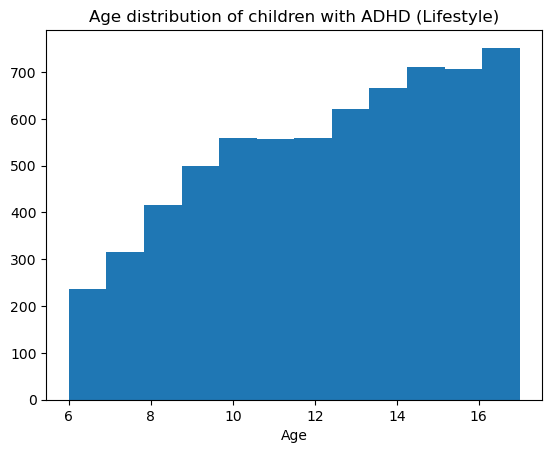

In [22]:
# age distribution of those with ADD (lifestyle)
graph = df[lifestyle_features + [target_variable, 'sc_age_years']].dropna()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
graph[graph['ADD_IND']].hist(column='sc_age_years', bins=12, ax=ax, grid=False)
ax.set_xlabel("Age")
ax.set_title("Age distribution of children with ADHD (Lifestyle)")

In [80]:
# ### Parental- Included
# - A1_ACTIVE ‐ Adult 1 ‐ Active Duty (T1 T2 T3)
# - A1_AGE ‐ Adult 1 ‐ Age in Years (T1 T2 T3)
# - A1_BORN ‐ Adult 1 ‐ Where Born (T1 T2 T3)
# - A1_EMPLOYED ‐ Adult 1 ‐ Current Employment Status (T1 T2 T3)
# - A1_GRADE ‐ Adult 1 ‐ Highest Completed Year of School (T1 T2 T3)
# - A1_MARITAL ‐ Adult 1 ‐ Marital Status (T1 T2 T3)
# - A1_MENTHEALTH ‐ Adult 1 ‐ Mental or Emotional Health (T1 T2 T3)
# - A1_PHYSHEALTH ‐ Adult 1 ‐ Physical Health (T1 T2 T3)
# - A1_RELATION ‐ Adult 1 ‐ How Related to Child (T1 T2 T3)
# - A1_SEX ‐ Adult 1 ‐ Sex (T1 T2 T3)
# - All of the above, for A2 (Adult 2)
# - ACE3 ‐ Child Experienced ‐ Parent or Guardian Divorced (T1 T2 T3)
# - ACE4 ‐ Child Experienced ‐ Parent or Guardian Died (T1 T2 T3)
# - ACE5 ‐ Child Experienced ‐ Parent or Guardian Time in Jail (T1 T2 T3)
# - ACE6 ‐ Child Experienced ‐ Adults Slap, Hit, Kick, Punch Others (T1 T2 T3)
# - AGEPOS4 ‐ Birth Order of Selected Children in Household (S1) 
# - ALLERGIES ‐ Allergies (T1 T2 T3) 
# - HIGRADE ‐ Highest Level of Education among Reported Adults (T1 T2 T3)
# - HIGRADE_TVIS ‐ Highest Level of Education among Reported Adults, Detail (T1 T2 T3)
# - MOMAGE ‐ Age of Mother ‐ Years (T1 T2 T3) 


# things relating to parental circumstances, or genetics
# technically should add ace7, ace8, ace9 to lifestyle
parental_features = ['a1_active', 'a1_age', 'a1_born', 'a1_employed', 'a1_grade', 
                     'a1_marital', 'a1_menthealth', 'a1_physhealth', 'a1_relation', 'a1_sex', 'a2_active', 'a2_age', 
                     'a2_born', 'a2_employed', 'a2_grade', 'a2_marital', 'a2_menthealth',
                     'a2_physhealth', 'a2_relation', 'a2_sex', 'ace3', 'ace4', 'ace5', 'ace6', 
                     'agepos4', 'allergies', 'higrade', 'higrade_tvis', 'momage']

In [81]:
parental_data = df[parental_features + [target_variable]].dropna()

num_add = parental_data[target_variable].sum()
total = len(parental_data)
print("Number of selected features:", len(parental_features))
print("Number of ADD:", num_add)
print("Total:", total)
print("Percentage ADD:", num_add/total * 100)

Number of selected features: 29
Number of ADD: 6415
Total: 78881
Percentage ADD: 8.132503391184189


Text(0.5, 1.0, 'Age distribution of children with ADHD (Parental)')

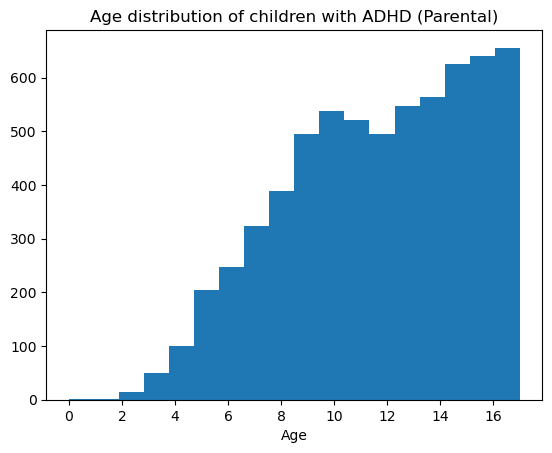

In [55]:
# age distribution of those with ADD (parental)
graph = df[parental_features + [target_variable, 'sc_age_years']].dropna()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
graph[graph['ADD_IND']].hist(column='sc_age_years', bins=18, ax=ax, grid=False)
ax.set_xlabel("Age")
ax.set_title("Age distribution of children with ADHD (Parental)")

In [26]:
### Socioeconomic- Excluded for now
# ** NOT ON 2021 ** 
# - EBTCARDS ‐ School Meal Debit  (T1 T2 T3)
# - EVERHOMELESS ‐ Homeless or Lived in Shelter  (T1 T2 T3)
# - HOMEEVIC ‐ Worried about Being Evicted  (T1 T2 T3)
# - MISSMORTGAGE ‐ Not Able to Pay Mortgage or Rent (T1 T2 T3) 
# - SSI ‐ Receive SSI  (T1 T2 T3) 
# - INQ_EDU ‐ Black‐White educational inequity (Supplemental)

 ### Socioeconomic- Included
# - ACE1 ‐ Hard to Cover Basics Like Food or Housing (T1 T2 T3)
# - CURRCOV ‐ Health Insurance Coverage ‐ Currently Covered (Use CURRINS) (T1 T2 T3)
# - FOODSIT ‐ Food Situation In Household ‐ Past 12 Months (T1 T2 T3)
# - FPL_I1 ‐ Family Poverty Ratio, First Implicate (T1 T2 T3)
# - K11Q60 ‐ Cash Assistance from Government ‐ Past 12 Months (T1 T2 T3)
# - K11Q61 ‐ Food Stamps ‐ Past 12 Months (T1 T2 T3)
# - K11Q62 ‐ Free or Reduced Cost Meals ‐ Past 12 Months (T1 T2 T3)
# - K3Q04_R ‐ Health Insurance Coverage ‐ Past 12 Months (Use INSGAP) (T1 T2 T3)
# - S9Q34 ‐ WIC Benefits ‐ Past 12 Months (T1 T2 T3) 
# - TENURE ‐ The Conditions under Which Land or Buildings Are Held or Occupied (S1)  
# - INSGAP ‐ Health Insurance Coverage ‐ Past 12 Months (T1 T2 T3)
# - INSTYPE ‐ Insurance Type (Revised) (T1 T2 T3)
# - K10Q11 ‐ Neighborhood ‐ Sidewalks or Walking Paths (T1 T2 T3) to K10Q40_R ‐ Child Is Safe In Neighborhood (T1 T2 T3)

# things relating to economic circumstances, e.g. monetary or residential issues
economic_features = ['ace1', 'currcov', 'foodsit', 'fpl_i1', 'k11q60', 'k11q61', 
                     'k11q62', 'k3q04_r', 's9q34', 'tenure', 'insgap', 'instype', 
                     'k10q11', 'k10q12', 'k10q13', 'k10q14', 'k10q20', 'k10q22', 'k10q23', 'k10q30', 'k10q31',  'k10q40_r']

In [60]:
economic_data = df[economic_features + [target_variable]].dropna()

num_add = economic_data[target_variable].sum()
total = len(economic_data)
print("Number of selected features:", len(economic_features))
print("Number of ADD:", num_add)
print("Total:", total)
print("Percentage ADD:", num_add/total * 100)

Number of selected features: 22
Number of ADD: 8613
Total: 95381
Percentage ADD: 9.03010033444816


Text(0.5, 1.0, 'Age distribution of children with ADHD (Socioeconomic)')

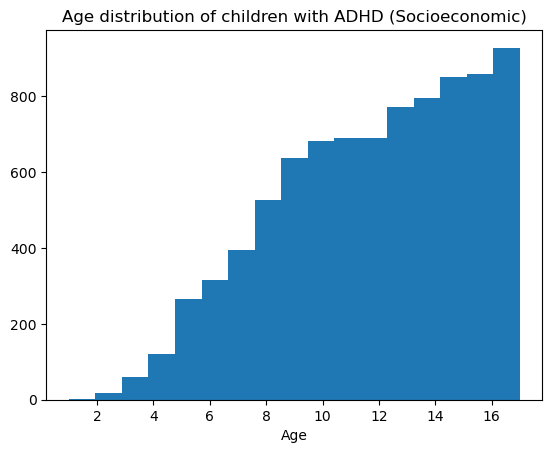

In [57]:
# age distribution of those with ADD (economic)
graph = df[economic_features + [target_variable, 'sc_age_years']].dropna()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
graph[graph['ADD_IND']].hist(column='sc_age_years', bins=17, ax=ax, grid=False)
ax.set_xlabel("Age")
ax.set_title("Age distribution of children with ADHD (Socioeconomic)")

In [82]:
#Repeat same steps but features are economic variables 

data = df.copy()
#select desired variables
data_final = data[economic_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[economic_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.4
test_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state = 26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state = 26)



Random Forest - Validation Accuracy: 0.90
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     34692
        True       0.14      0.02      0.03      3460

    accuracy                           0.90     38152
   macro avg       0.52      0.50      0.49     38152
weighted avg       0.84      0.90      0.86     38152

[[34326   366]
 [ 3402    58]]


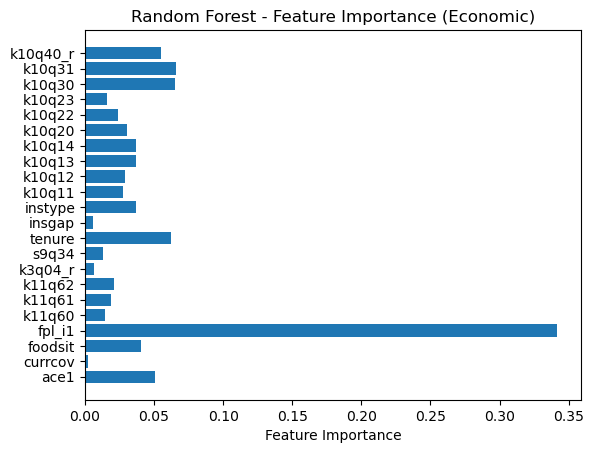

In [83]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Random Forest - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(economic_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance (Socioeconomic)')
plt.show()

Logistic Regression - Validation Accuracy: 0.91
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     34692
        True       0.00      0.00      0.00      3460

    accuracy                           0.91     38152
   macro avg       0.45      0.50      0.48     38152
weighted avg       0.83      0.91      0.87     38152

[[34692     0]
 [ 3460     0]]


C:\Users\Michael\anaconda3\envs\cs590w\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Michael\anaconda3\envs\cs590w\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Michael\anaconda3\envs\cs590w\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



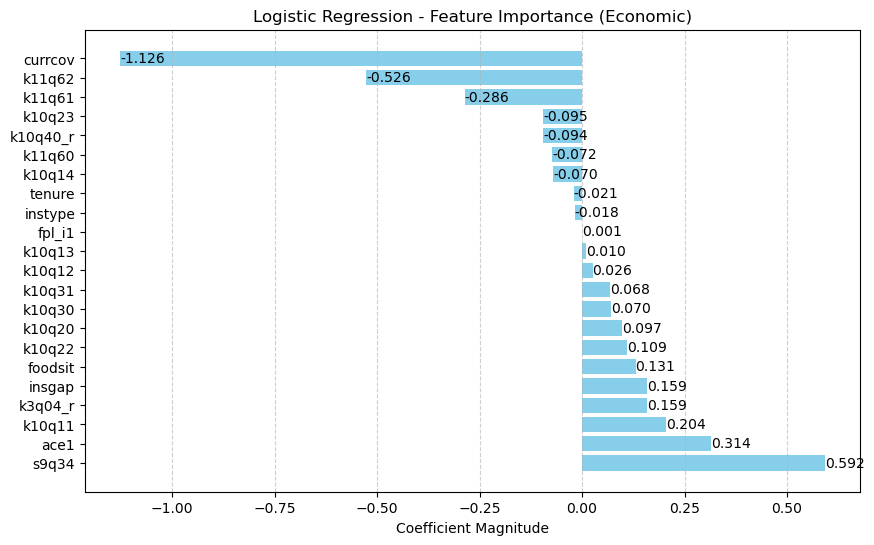

In [84]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance (Socioeconomic)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [85]:
#Repeat same steps but features are parental variables (n = 109)

data = df.copy()

#select desired variables#select desired variables
data_final = data[parental_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[parental_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.45
validation_size = 0.3
test_size = 0.25

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size))



Random Forest - Validation Accuracy: 0.92
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     21734
        True       0.21      0.00      0.00      1930

    accuracy                           0.92     23664
   macro avg       0.56      0.50      0.48     23664
weighted avg       0.86      0.92      0.88     23664

[[21719    15]
 [ 1926     4]]


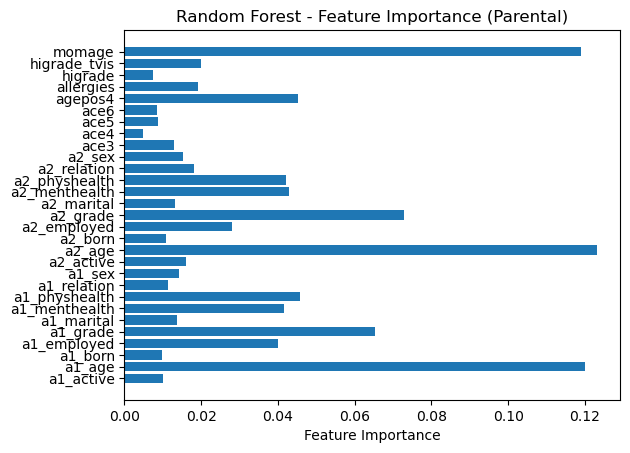

In [86]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Random Forest - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(parental_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance (Parental)')
plt.show()

Logistic Regression - Validation Accuracy: 0.92
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     21734
        True       0.32      0.02      0.04      1930

    accuracy                           0.92     23664
   macro avg       0.62      0.51      0.50     23664
weighted avg       0.87      0.92      0.88     23664

[[21649    85]
 [ 1890    40]]


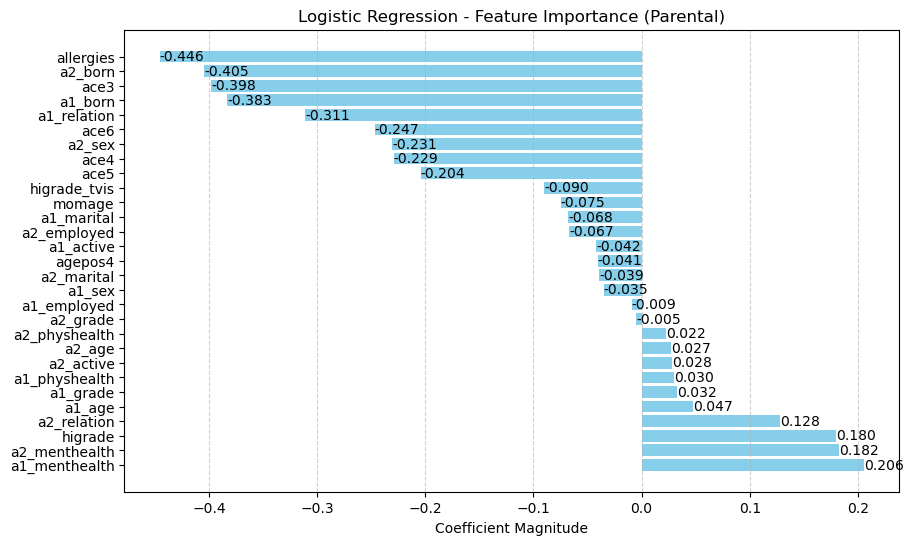

In [87]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance (Parental)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [88]:
#Repeat same steps but features are lifestyle variables (n = 12,111)

data = df.copy()


# # Combine diagnosis and severity into a new target variable ranging from 0 to 3
# data['k2q31a'] = data['k2q31a'].apply(lambda x: 0 if x == 2 else 1) #assign 0 to 'No' instead of 2
# data['ADD_SEVERITY'] = data['k2q31a'] * data['k2q31c'].fillna(0)
# target_variable = 'ADD_SEVERITY'

# #select desired variables
# lifestyle_features = ['avoidchg', 'bedtime', 'birth_yr',
#                      'birthwt', 'bmiclass', 'bornusa', 'bullied_r', 'overweight',
#                       'bully', 'concussion', 'covidarrange', 'screentime', 'physactiv',
#                      'goforhelp', 'height', 'hhcount','higrade_tvis', 'hopeful', 'insgap', 'k10q11', 'k10q12','k10q13', 
#                       'k10q14', 'k10q20', 'k10q22', 'k10q23', 'k10q30', 'k10q31', 'k10q40_r', 'k10q41_r', 'k11q43r', 'k2q01', 
#                       'k2q05', 'wktosolve', 'sc_age_years', 'placeslived', 'sc_english', 'vape', 'talkabout']
# # Convert categorical columns to numerical
# data_conv = data.copy()
# categ = ['inq_edu', 'inq_employ', 'inq_home', 'inq_income', 'inq_resseg']
# data_conv[categ] = data[categ].replace({'LOW': 0, 'HIGH': 1})

# data_final = data_conv[lifestyle_features + categ + [target_variable]]
data_final = data[lifestyle_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[lifestyle_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.3
test_size = 0.2

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state = 42)


Random Forest - Validation Accuracy: 0.86
              precision    recall  f1-score   support

       False       0.86      1.00      0.93     12149
        True       0.47      0.01      0.02      1953

    accuracy                           0.86     14102
   macro avg       0.67      0.51      0.47     14102
weighted avg       0.81      0.86      0.80     14102

[[12122    27]
 [ 1929    24]]


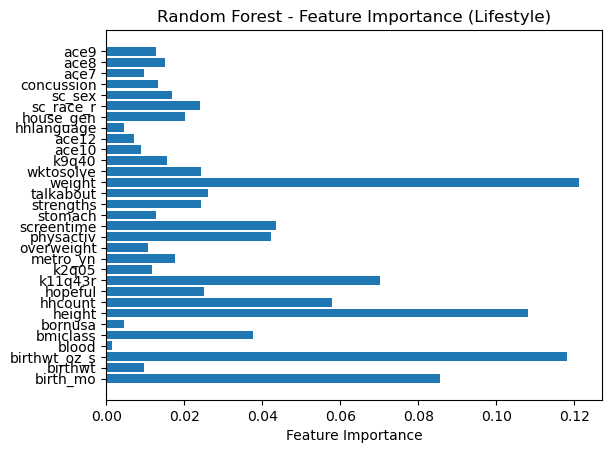

In [89]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Random Forest - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(lifestyle_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance (Lifestyle)')
plt.show()

Logistic Regression - Validation Accuracy: 0.86
              precision    recall  f1-score   support

       False       0.86      0.99      0.92     12149
        True       0.44      0.03      0.05      1953

    accuracy                           0.86     14102
   macro avg       0.65      0.51      0.49     14102
weighted avg       0.80      0.86      0.80     14102

[[12079    70]
 [ 1899    54]]


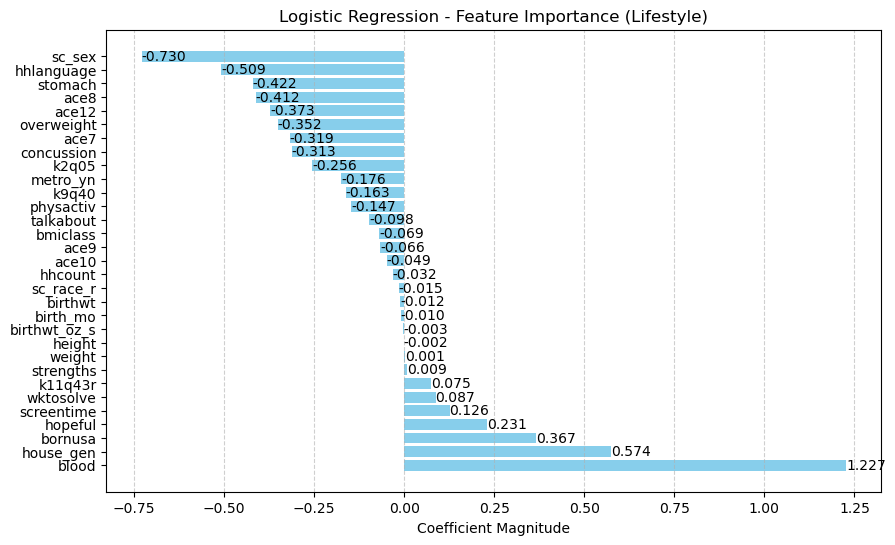

In [90]:
#Logistic Regression
model = LogisticRegression(max_iter = 3000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance (Lifestyle)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [40]:
# #Gaussian Process Classifier
# model = GaussianProcessClassifier()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'Gaussian Process Classifier - Validation Accuracy: {accuracy:.2f}')
# print(classification_report(y_val, y_pred))
# print(confusion_matrix(y_val, y_pred))

In [41]:
# # SVM with Linear Kernel
# model = SVC(kernel = 'linear')
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'SVC (Linear) - Validation Accuracy: {accuracy:.2f}')
# print(classification_report(y_val, y_pred))
# print(confusion_matrix(y_val, y_pred))

In [42]:
# # SVM with Polynomial Kernel
# model = SVC(kernel = 'poly', degree = 3)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(f'SVC (Polynomial) - Validation Accuracy: {accuracy:.2f}')
# print(classification_report(y_val, y_pred))
# print(confusion_matrix(y_val, y_pred))

In [91]:
# Combining the strongest features from each category
data = df.copy()

# refine feature sets, removing some unnoticed or potential covariates
# unchanged
lifestyle_features = ['birth_mo', 'birthwt', 'birthwt_oz_s', 'blood', 'bmiclass', 'bornusa', 'height', 'hhcount', 
                      'hopeful', 'k11q43r', 'k2q05', 'metro_yn', 'overweight', 'physactiv', 'screentime', 
                      'stomach', 'strengths', 'talkabout', 'weight', 'wktosolve', 'k9q40', 'ace10', 'ace12', 'hhlanguage', 
                      'house_gen', 'sc_race_r', 'sc_sex', 'concussion', 'ace7', 'ace8', 'ace9']

# removed ages, as it may be related to child's age, and child's age is correlated with adhd diagnosis
parental_features = ['a1_active', 'a1_born', 'a1_employed', 'a1_grade', 
                     'a1_marital', 'a1_menthealth', 'a1_physhealth', 'a1_relation', 'a1_sex', 'a2_active', 
                     'a2_born', 'a2_employed', 'a2_grade', 'a2_marital', 'a2_menthealth',
                     'a2_physhealth', 'a2_relation', 'a2_sex', 'ace3', 'ace4', 'ace5', 'ace6', 
                     'agepos4', 'allergies', 'higrade', 'higrade_tvis']

# unchanged
economic_features = ['ace1', 'currcov', 'foodsit', 'fpl_i1', 'k11q60', 'k11q61', 
                     'k11q62', 'k3q04_r', 's9q34', 'tenure', 'insgap', 'instype', 
                     'k10q11', 'k10q12', 'k10q13', 'k10q14', 'k10q20', 'k10q22', 'k10q23', 'k10q30', 'k10q31',  'k10q40_r']

#select desired variables
combo_features = lifestyle_features + parental_features + economic_features
# Convert categorical columns to numerical
# data_conv = data.copy()
# categ = ['inq_edu', 'inq_employ', 'inq_home', 'inq_income', 'inq_resseg']
# data_conv[categ] = data[categ].replace({'LOW': 0, 'HIGH': 1})

# data_final = data_conv[combo_features + [target_variable]]
data_final = data[combo_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[combo_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.27
test_size = 0.23

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size))


Number of selected features: 79
Number of ADD: 4661
Total: 35009
Percentage ADD: 13.313719329315319


Text(0.5, 1.0, 'Age distribution of children with ADHD (Combined)')

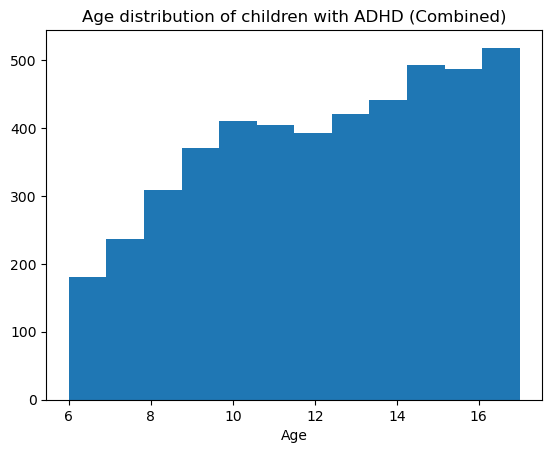

In [95]:
num_add = final[target_variable].sum()
total = len(final)
print("Number of selected features:", len(combo_features))
print("Number of ADD:", num_add)
print("Total:", total)
print("Percentage ADD:", num_add/total * 100)

# age distribution of those with ADD (economic)
graph = df[combo_features + [target_variable, 'sc_age_years']].dropna()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
graph[graph['ADD_IND']].hist(column='sc_age_years', bins=12, ax=ax, grid=False)
ax.set_xlabel("Age")
ax.set_title("Age distribution of children with ADHD (Combined)")

Random Forest - Validation Accuracy: 0.87
              precision    recall  f1-score   support

       False       0.87      1.00      0.93      8216
        True       0.67      0.01      0.01      1236

    accuracy                           0.87      9452
   macro avg       0.77      0.50      0.47      9452
weighted avg       0.84      0.87      0.81      9452

[[8212    4]
 [1228    8]]


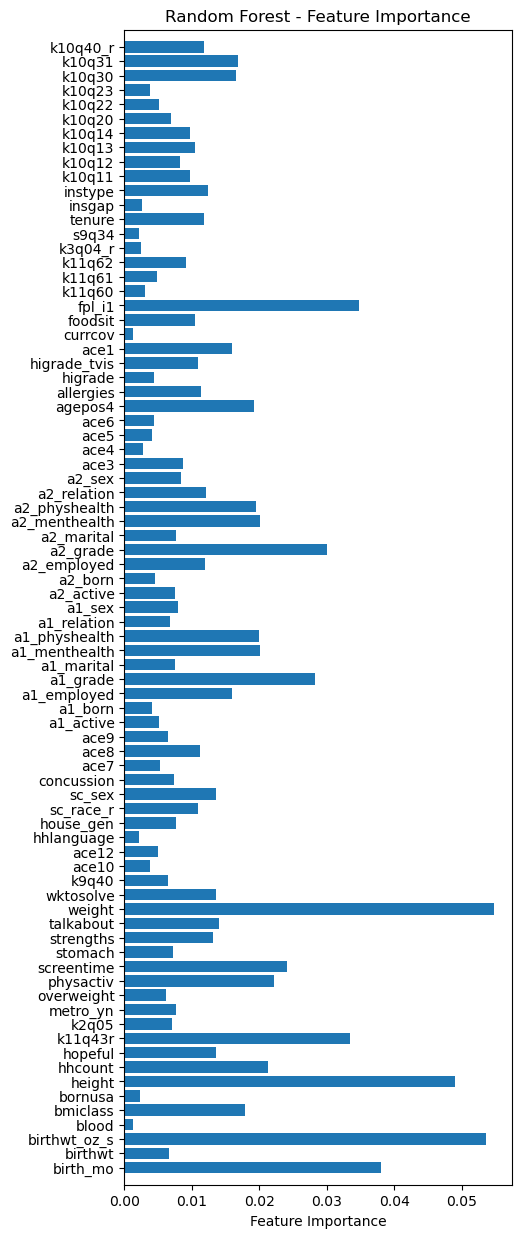

In [114]:
# Random Forest
model_ = RandomForestClassifier(n_estimators=1000)
model_.fit(X_train, y_train)
y_pred = model_.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Random Forest - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model_.feature_importances_
plt.figure(figsize=(5, 15))
plt.margins(y=0.01)
plt.barh(combo_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [101]:
sum(y_pred)/(sum(y_val))

0.012135922330097087

In [102]:
##### feature_importance

In [103]:
len(combo_features)

79

Logistic Regression - Validation Accuracy: 0.87
              precision    recall  f1-score   support

       False       0.87      0.99      0.93      8216
        True       0.53      0.05      0.08      1236

    accuracy                           0.87      9452
   macro avg       0.70      0.52      0.51      9452
weighted avg       0.83      0.87      0.82      9452

[[8166   50]
 [1180   56]]


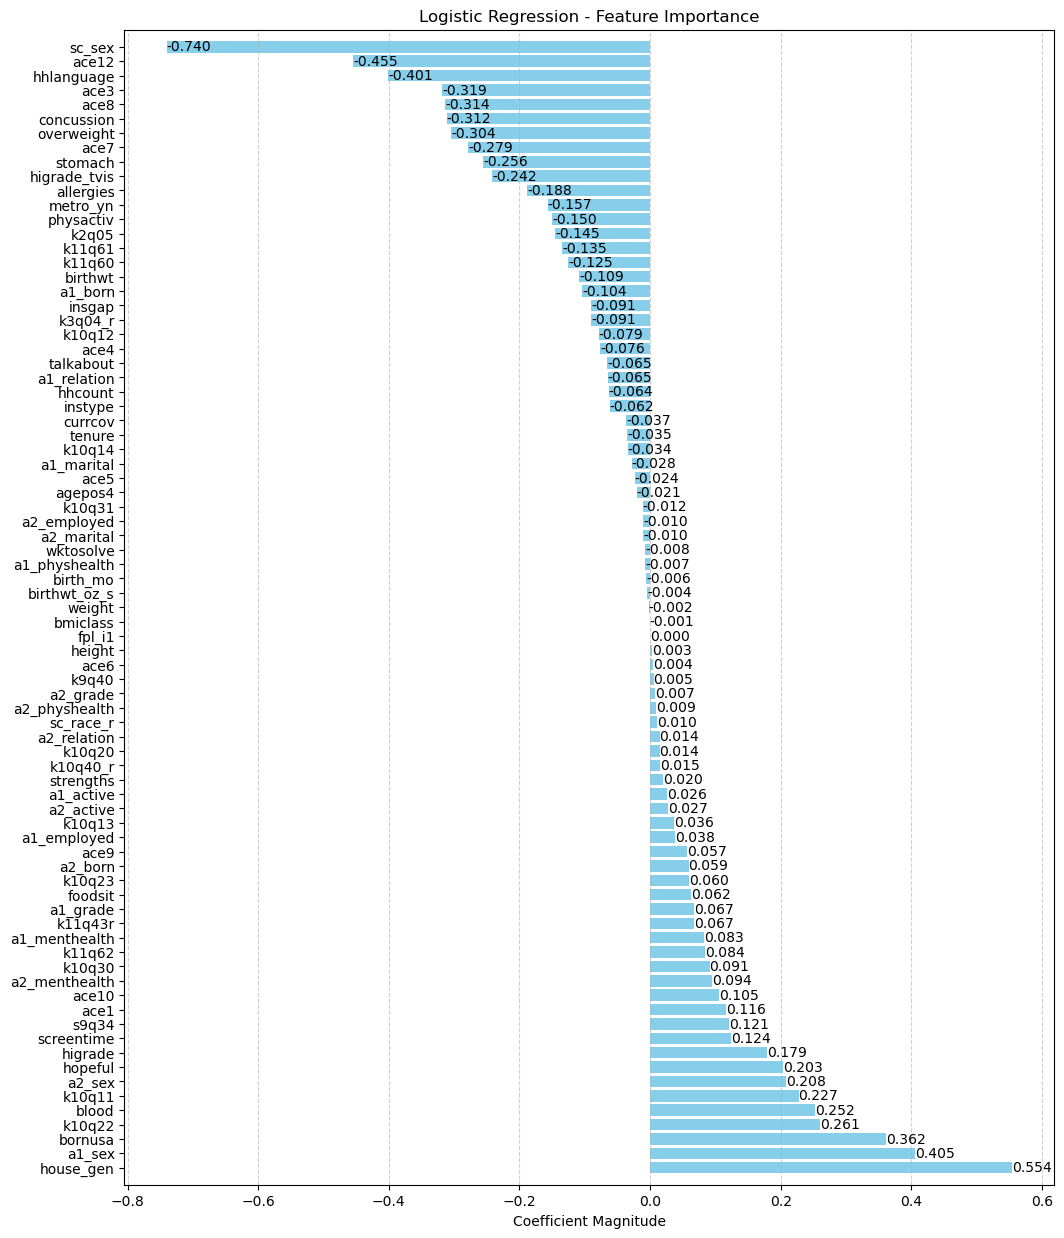

In [148]:
#Logistic Regression
model = LogisticRegression(max_iter = 3000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 15))
plt.margins(y=0.01)
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

Best Model - Test Accuracy: 0.86
              precision    recall  f1-score   support

       False       0.87      0.99      0.93      6969
        True       0.40      0.03      0.06      1084

    accuracy                           0.86      8053
   macro avg       0.64      0.51      0.49      8053
weighted avg       0.81      0.86      0.81      8053

[[6916   53]
 [1048   36]]


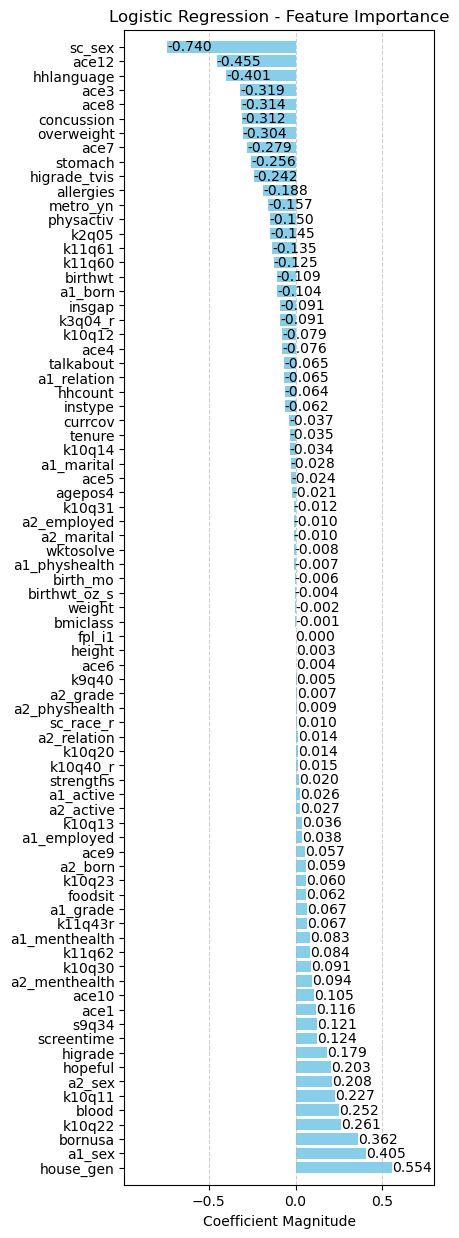

In [174]:
# Logistic regression on test set
lr_full = LogisticRegression(max_iter=3000)  # Change this based on the best-performing model from validation
lr_full.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Mangitude of Coefficients
coefficients = lr_full.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(4, 15))
plt.margins(y=0.01)
plt.margins(x=0.19)
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [134]:
roc_auc = roc_auc_score(y_test, lr_full.predict_proba(X_test)[:, 1])
print(roc_auc)

0.7073910343063827


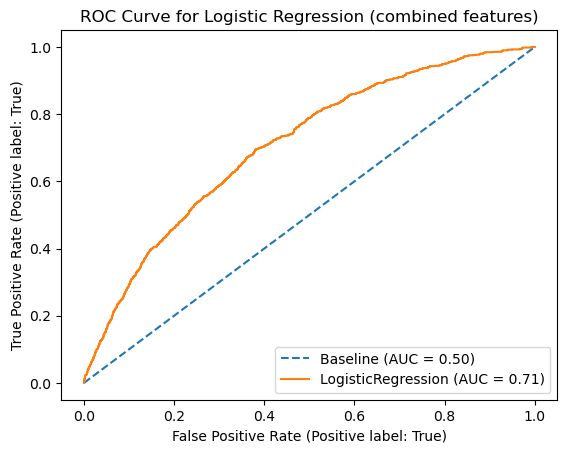

In [166]:
fig, ax = plt.subplots()
ax.set_title("ROC Curve for Logistic Regression (combined features)")
plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline (AUC = 0.50)')
RocCurveDisplay.from_estimator(lr_full, X_test, y_test, ax=ax)

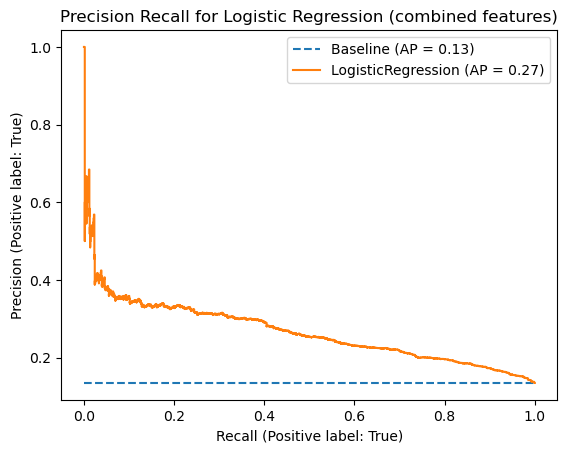

In [165]:
fig, ax = plt.subplots()
ax.set_title("Precision Recall for Logistic Regression (combined features)")
baseline = sum(y_test)/len(y_test)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label=f'Baseline (AP = {round(baseline, 2)})')
PrecisionRecallDisplay.from_estimator(lr_full, X_test, y_test, ax=ax)
plt.legend(loc=1)

Random Forest - Validation Accuracy: 0.87
              precision    recall  f1-score   support

       False       0.87      1.00      0.93      6969
        True       0.50      0.00      0.01      1084

    accuracy                           0.87      8053
   macro avg       0.68      0.50      0.47      8053
weighted avg       0.82      0.87      0.80      8053

[[6965    4]
 [1080    4]]


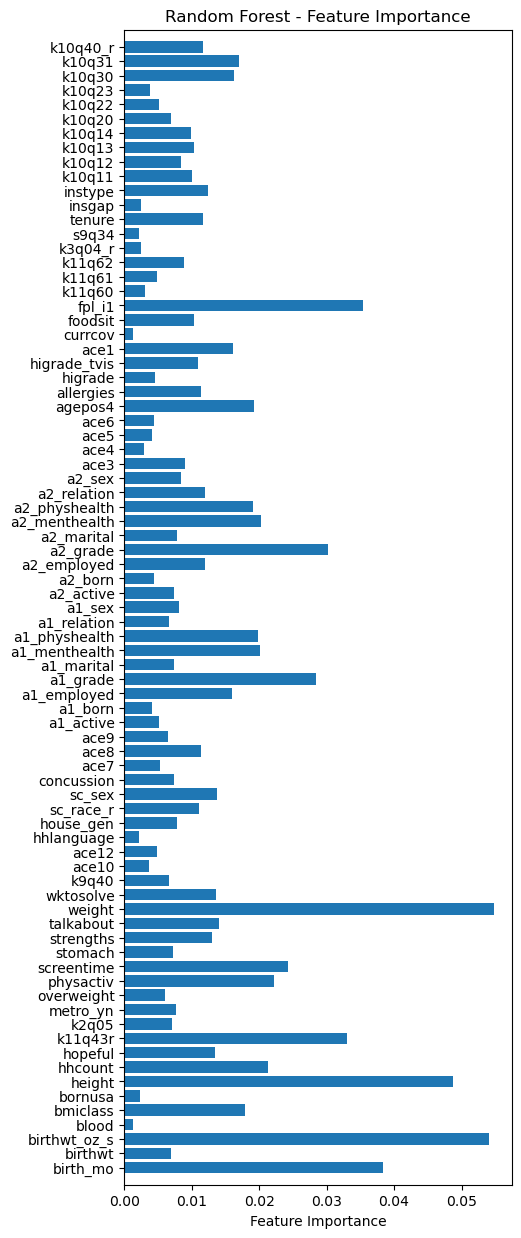

In [175]:
# Random Forest on test set
forest_full = RandomForestClassifier(n_estimators=1000)
forest_full.fit(X_train, y_train)
y_pred = model_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = forest_full.feature_importances_
plt.figure(figsize=(5, 15))
plt.margins(y=0.01)
plt.barh(combo_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [135]:
roc_auc = roc_auc_score(y_test, forest_full.predict_proba(X_test)[:, 1])
print(roc_auc)

0.6967999824208315


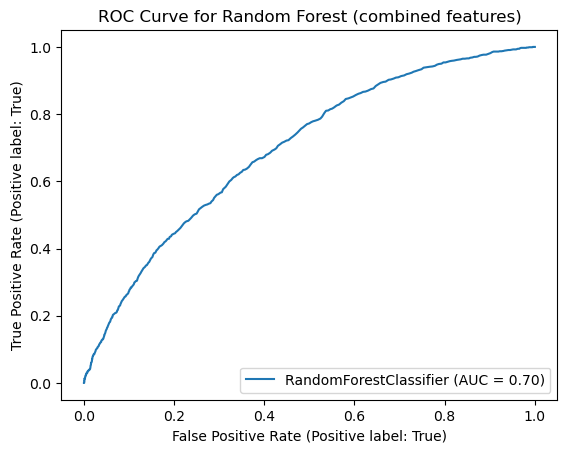

In [142]:
fig, ax = plt.subplots()
ax.set_title("ROC Curve for Random Forest (combined features)")
plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline (AUC = 0.50)')
RocCurveDisplay.from_estimator(forest_full, X_test, y_test, ax=ax)

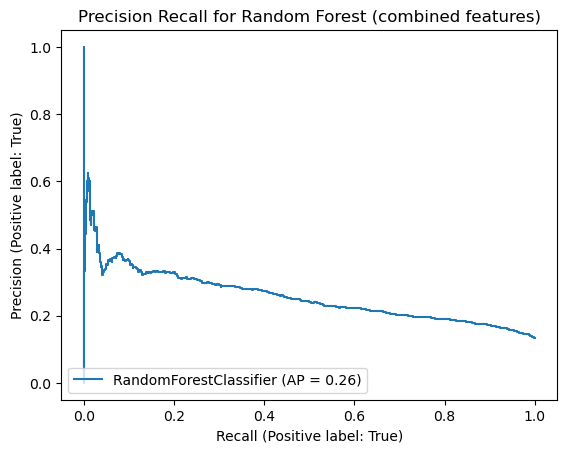

In [144]:
fig, ax = plt.subplots()
ax.set_title("Precision Recall for Random F (combined features)")
baseline = sum(y_test)/len(y_test)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label=f'Baseline (AP = {round(baseline, 2)})')
PrecisionRecallDisplay.from_estimator(lr_full, X_test, y_test, ax=ax)
plt.legend(loc=1)